# Group Comparisons Analysis (RQ2)

**Research Question 2:** How do ethical concerns about ChatGPT vary by usage frequency, discipline, and demographics?

**Team:** Team 5  
**Date:** November 2025

## 1. Setup

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind, kruskal
from pathlib import Path

pd.set_option('display.float_format', '{:.3f}'.format)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

output_dir = Path('../../results/tables')

print("✅ Libraries loaded")


✅ Libraries loaded


In [7]:
# Load data
df = pd.read_csv('../../data/cleaned/cleaned_data.csv')
print(f"Loaded: {len(df):,} students")

Loaded: 22,836 students


C:\Users\SHASHANK.G.S\AppData\Local\Temp\ipykernel_26668\951674864.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/cleaned/cleaned_data.csv')


## 2. Group Comparisons by Usage Frequency

### 2.1 Descriptive Statistics by Usage

In [8]:
if 'usage_label' in df.columns:
    # Key variables to compare
    compare_vars = ['Q15', 'ethics_concerns_score', 'capabilities_score', 'attitudes_score']
    compare_vars = [v for v in compare_vars if v in df.columns]
    
    print("\n" + "="*80)
    print("DESCRIPTIVE STATISTICS BY USAGE FREQUENCY")
    print("="*80 + "\n")
    
    usage_summary = df.groupby('usage_label')[compare_vars].agg(['mean', 'std', 'count'])
    print(usage_summary.round(3))
    
    # Save
    output_dir.mkdir(parents=True, exist_ok=True)
    usage_summary.to_csv(output_dir / 'group_comparison_usage.csv')
else:
    print("⚠️ Usage label not found")


DESCRIPTIVE STATISTICS BY USAGE FREQUENCY

              Q15              ethics_concerns_score               \
             mean   std  count                  mean   std  count   
usage_label                                                         
Daily       2.758 1.133  15123                 3.343 0.738  12576   
Monthly     2.780 1.161    645                 3.334 0.776    513   
Weekly      2.867 1.153   3623                 3.321 0.757   3079   

            capabilities_score              attitudes_score               
                          mean   std  count            mean   std  count  
usage_label                                                               
Daily                    2.944 0.872  13936           3.328 0.834  13932  
Monthly                  3.204 0.855    575           3.641 0.926    577  
Weekly                   3.103 0.800   3358           3.402 0.868   3361  


### 2.2 ANOVA: Ethical Concerns by Usage

In [9]:
if 'usage_label' in df.columns and 'ethics_concerns_score' in df.columns:
    # Separate groups
    daily = df[df['usage_label'] == 'Daily']['ethics_concerns_score'].dropna()
    weekly = df[df['usage_label'] == 'Weekly']['ethics_concerns_score'].dropna()
    monthly = df[df['usage_label'] == 'Monthly']['ethics_concerns_score'].dropna()
    
    # One-way ANOVA
    f_stat, p_val = f_oneway(daily, weekly, monthly)
    
    print("\n" + "="*80)
    print("ONE-WAY ANOVA: Ethical Concerns by Usage Frequency")
    print("="*80)
    print(f"\nF-statistic = {f_stat:.4f}")
    print(f"p-value = {p_val:.4e}")
    
    if p_val < 0.05:
        print("\n✅ Significant difference between groups (p < 0.05)")
    else:
        print("\n❌ No significant difference between groups (p ≥ 0.05)")
    
    # Group means
    print("\nGroup Means:")
    print(f"  Daily:   M = {daily.mean():.3f}, SD = {daily.std():.3f}, N = {len(daily)}")
    print(f"  Weekly:  M = {weekly.mean():.3f}, SD = {weekly.std():.3f}, N = {len(weekly)}")
    print(f"  Monthly: M = {monthly.mean():.3f}, SD = {monthly.std():.3f}, N = {len(monthly)}")
    
    # Calculate effect size (eta-squared)
    grand_mean = df['ethics_concerns_score'].mean()
    ss_between = (len(daily) * (daily.mean() - grand_mean)**2 + 
                  len(weekly) * (weekly.mean() - grand_mean)**2 + 
                  len(monthly) * (monthly.mean() - grand_mean)**2)
    ss_total = ((df['ethics_concerns_score'] - grand_mean)**2).sum()
    eta_squared = ss_between / ss_total
    
    print(f"\nEffect Size (η²) = {eta_squared:.4f}")
    
    if eta_squared < 0.01:
        print("  (Small effect)")
    elif eta_squared < 0.06:
        print("  (Medium effect)")
    else:
        print("  (Large effect)")


ONE-WAY ANOVA: Ethical Concerns by Usage Frequency

F-statistic = 1.1240
p-value = 3.2501e-01

❌ No significant difference between groups (p ≥ 0.05)

Group Means:
  Daily:   M = 3.343, SD = 0.738, N = 12576
  Weekly:  M = 3.321, SD = 0.757, N = 3079
  Monthly: M = 3.334, SD = 0.776, N = 513

Effect Size (η²) = 0.0001
  (Small effect)


### 2.3 Post-hoc Pairwise Comparisons

In [10]:
if 'usage_label' in df.columns and 'ethics_concerns_score' in df.columns:
    print("\n" + "="*80)
    print("POST-HOC PAIRWISE T-TESTS")
    print("="*80)
    
    # Daily vs Weekly
    t1, p1 = ttest_ind(daily, weekly)
    print(f"\nDaily vs Weekly:")
    print(f"  t = {t1:.4f}, p = {p1:.4f} {'***' if p1 < 0.001 else '**' if p1 < 0.01 else '*' if p1 < 0.05 else 'ns'}")
    
    # Daily vs Monthly
    t2, p2 = ttest_ind(daily, monthly)
    print(f"\nDaily vs Monthly:")
    print(f"  t = {t2:.4f}, p = {p2:.4f} {'***' if p2 < 0.001 else '**' if p2 < 0.01 else '*' if p2 < 0.05 else 'ns'}")
    
    # Weekly vs Monthly
    t3, p3 = ttest_ind(weekly, monthly)
    print(f"\nWeekly vs Monthly:")
    print(f"  t = {t3:.4f}, p = {p3:.4f} {'***' if p3 < 0.001 else '**' if p3 < 0.01 else '*' if p3 < 0.05 else 'ns'}")
    
    print("\nNote: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
    print("      Consider Bonferroni correction for multiple comparisons (α = 0.05/3 = 0.0167)")


POST-HOC PAIRWISE T-TESTS

Daily vs Weekly:
  t = 1.4964, p = 0.1346 ns

Daily vs Monthly:
  t = 0.2559, p = 0.7980 ns

Weekly vs Monthly:
  t = -0.3806, p = 0.7035 ns

Note: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant
      Consider Bonferroni correction for multiple comparisons (α = 0.05/3 = 0.0167)


## 3. Visualizations

### 3.1 Box Plots by Usage

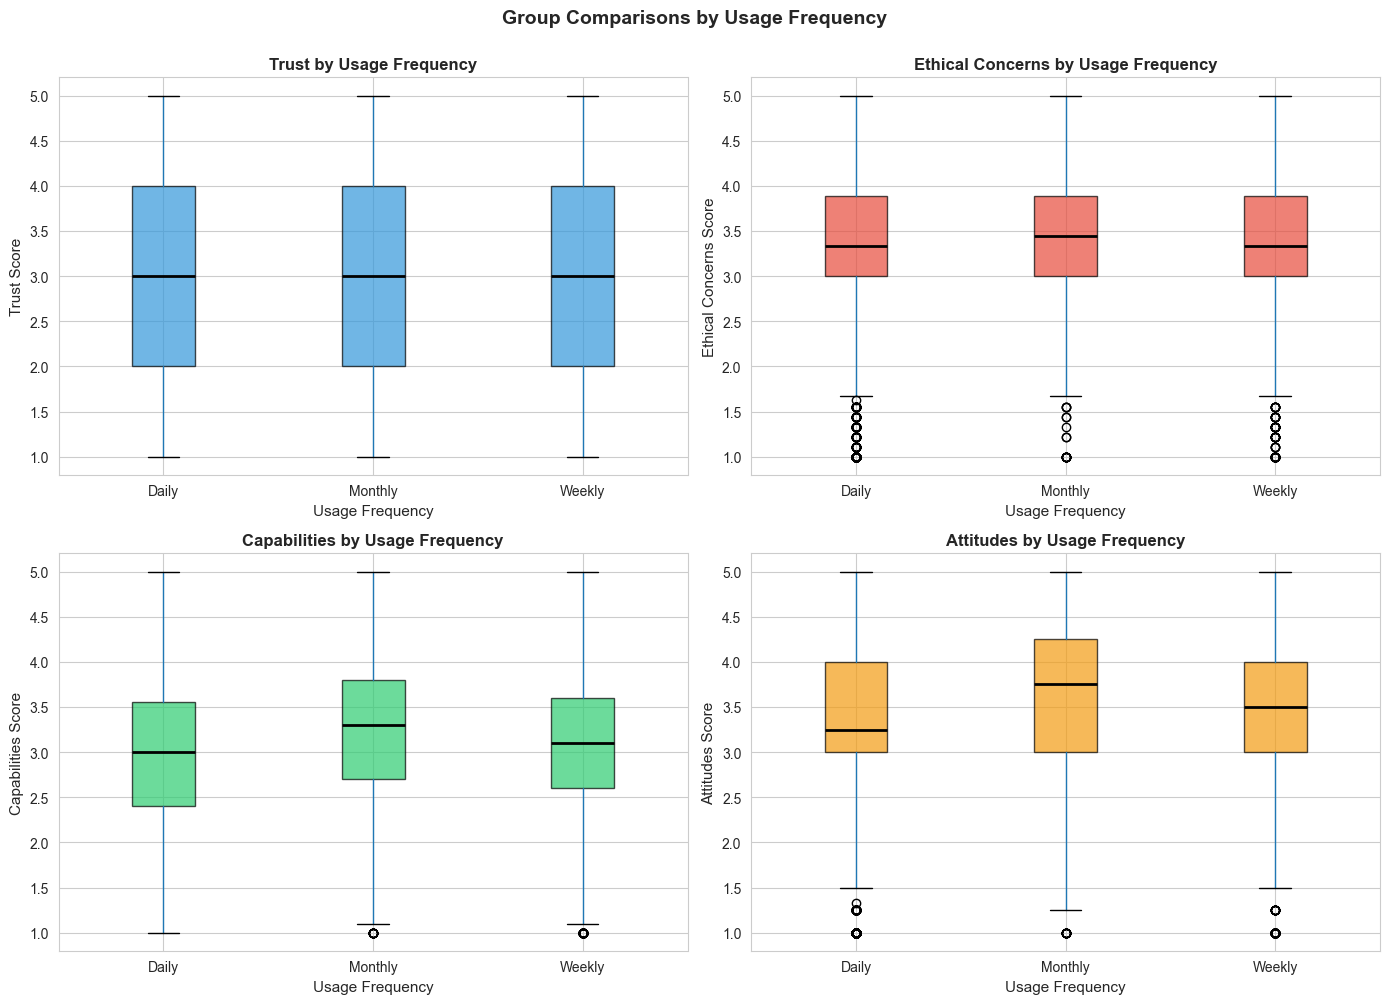

✅ Boxplots saved to results/figures/boxplots_by_usage.png


In [11]:
if 'usage_label' in df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    plot_vars = ['Q15', 'ethics_concerns_score', 'capabilities_score', 'attitudes_score']
    plot_titles = ['Trust', 'Ethical Concerns', 'Capabilities', 'Attitudes']
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    
    for idx, (var, title, color) in enumerate(zip(plot_vars, plot_titles, colors)):
        if var in df.columns:
            df.boxplot(column=var, by='usage_label', ax=axes[idx], 
                      patch_artist=True, 
                      boxprops=dict(facecolor=color, alpha=0.7),
                      medianprops=dict(color='black', linewidth=2))
            
            axes[idx].set_title(f'{title} by Usage Frequency', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Usage Frequency', fontsize=11)
            axes[idx].set_ylabel(f'{title} Score', fontsize=11)
            axes[idx].get_figure().suptitle('')  # Remove default title
    
    plt.suptitle('Group Comparisons by Usage Frequency', 
                fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    
    # Save
    fig_dir = Path('../results/figures')
    fig_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(fig_dir / 'boxplots_by_usage.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    print("✅ Boxplots saved to results/figures/boxplots_by_usage.png")

### 3.2 Violin Plots

C:\Users\SHASHANK.G.S\AppData\Local\Temp\ipykernel_26668\3919291010.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='usage_label', y='ethics_concerns_score',


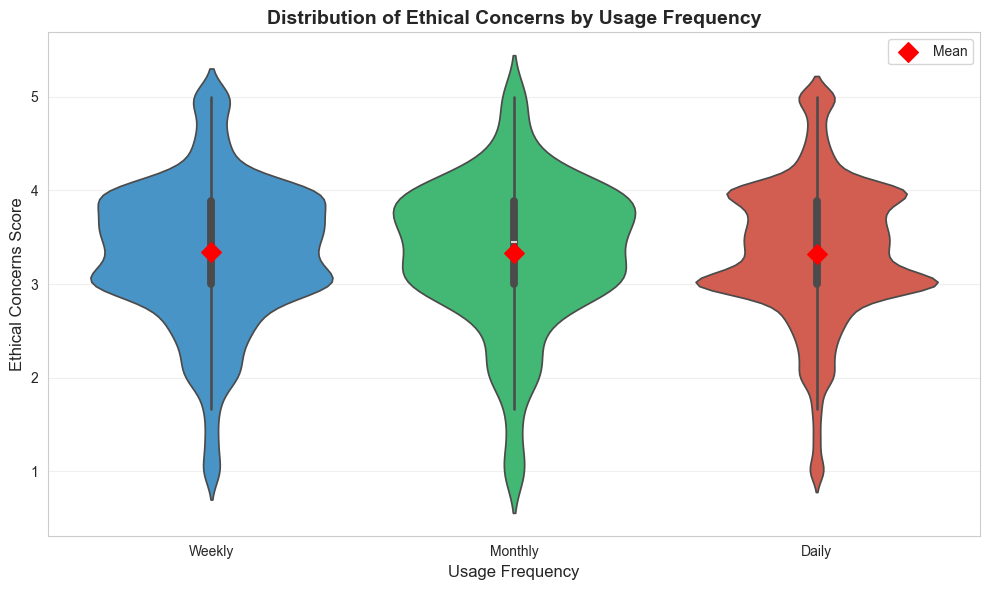

✅ Violin plot saved to results/figures/violin_ethics_by_usage.png


In [12]:
if 'usage_label' in df.columns and 'ethics_concerns_score' in df.columns:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.violinplot(data=df, x='usage_label', y='ethics_concerns_score', 
                  palette=['#3498db', '#2ecc71', '#e74c3c'], ax=ax)
    
    # Add mean markers
    means = df.groupby('usage_label')['ethics_concerns_score'].mean()
    positions = range(len(means))
    ax.scatter(positions, means, color='red', s=100, zorder=3, 
              marker='D', label='Mean')
    
    ax.set_title('Distribution of Ethical Concerns by Usage Frequency', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Usage Frequency', fontsize=12)
    ax.set_ylabel('Ethical Concerns Score', fontsize=12)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(fig_dir / 'violin_ethics_by_usage.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Violin plot saved to results/figures/violin_ethics_by_usage.png")

### 3.3 Bar Plot with Error Bars

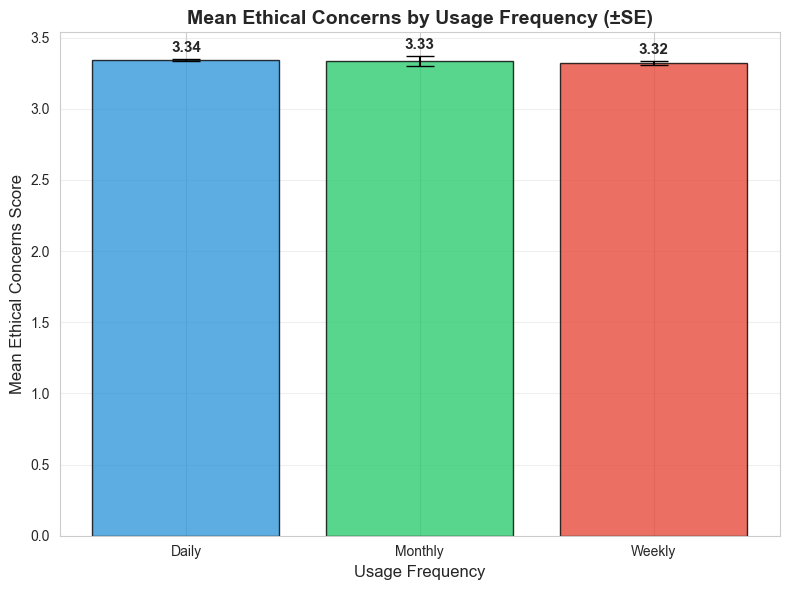

✅ Bar plot saved to results/figures/barplot_ethics_by_usage.png


In [13]:
if 'usage_label' in df.columns and 'ethics_concerns_score' in df.columns:
    # Calculate means and SEs
    group_stats = df.groupby('usage_label')['ethics_concerns_score'].agg(['mean', 'std', 'count'])
    group_stats['se'] = group_stats['std'] / np.sqrt(group_stats['count'])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    x_pos = np.arange(len(group_stats))
    
    bars = ax.bar(x_pos, group_stats['mean'], 
                  yerr=group_stats['se'],
                  capsize=10,
                  color=['#3498db', '#2ecc71', '#e74c3c'],
                  edgecolor='black',
                  alpha=0.8)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, group_stats['mean'])):
        ax.text(bar.get_x() + bar.get_width()/2, val + group_stats['se'].iloc[i] + 0.05,
               f'{val:.2f}', ha='center', fontsize=11, fontweight='bold')
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(group_stats.index)
    ax.set_xlabel('Usage Frequency', fontsize=12)
    ax.set_ylabel('Mean Ethical Concerns Score', fontsize=12)
    ax.set_title('Mean Ethical Concerns by Usage Frequency (±SE)', 
                fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(fig_dir / 'barplot_ethics_by_usage.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Bar plot saved to results/figures/barplot_ethics_by_usage.png")

## 4. Trust Differences by Usage

In [14]:
if 'usage_label' in df.columns and 'Q15' in df.columns:
    # ANOVA for Trust
    daily_trust = df[df['usage_label'] == 'Daily']['Q15'].dropna()
    weekly_trust = df[df['usage_label'] == 'Weekly']['Q15'].dropna()
    monthly_trust = df[df['usage_label'] == 'Monthly']['Q15'].dropna()
    
    f_stat, p_val = f_oneway(daily_trust, weekly_trust, monthly_trust)
    
    print("\n" + "="*80)
    print("ANOVA: Trust by Usage Frequency")
    print("="*80)
    print(f"\nF-statistic = {f_stat:.4f}")
    print(f"p-value = {p_val:.4e}")
    
    print("\nGroup Means:")
    print(f"  Daily:   M = {daily_trust.mean():.3f}")
    print(f"  Weekly:  M = {weekly_trust.mean():.3f}")
    print(f"  Monthly: M = {monthly_trust.mean():.3f}")


ANOVA: Trust by Usage Frequency

F-statistic = 13.3533
p-value = 1.6023e-06

Group Means:
  Daily:   M = 2.758
  Weekly:  M = 2.867
  Monthly: M = 2.780


## 5. Summary Table

In [15]:
if 'usage_label' in df.columns:
    # Create comprehensive summary
    summary_vars = ['Q15', 'ethics_concerns_score', 'capabilities_score', 'attitudes_score']
    summary_vars = [v for v in summary_vars if v in df.columns]
    
    summary_table = pd.DataFrame()
    
    for var in summary_vars:
        daily_data = df[df['usage_label'] == 'Daily'][var].dropna()
        weekly_data = df[df['usage_label'] == 'Weekly'][var].dropna()
        monthly_data = df[df['usage_label'] == 'Monthly'][var].dropna()
        
        # ANOVA
        f, p = f_oneway(daily_data, weekly_data, monthly_data)
        
        summary_table = pd.concat([summary_table, pd.DataFrame({
            'Variable': [var],
            'Daily_Mean': [daily_data.mean()],
            'Weekly_Mean': [weekly_data.mean()],
            'Monthly_Mean': [monthly_data.mean()],
            'F_statistic': [f],
            'p_value': [p],
            'Significant': ['Yes' if p < 0.05 else 'No']
        })], ignore_index=True)
    
    print("\n" + "="*80)
    print("SUMMARY OF GROUP COMPARISONS")
    print("="*80)
    print(summary_table.round(4).to_string(index=False))
    
    # Save
    summary_table.to_csv(output_dir / 'anova_summary.csv', index=False)
    print("\n✅ Summary saved to results/tables/anova_summary.csv")


SUMMARY OF GROUP COMPARISONS
             Variable  Daily_Mean  Weekly_Mean  Monthly_Mean  F_statistic  p_value Significant
                  Q15       2.758        2.867         2.780       13.353    0.000         Yes
ethics_concerns_score       3.343        3.321         3.334        1.124    0.325          No
   capabilities_score       2.944        3.103         3.204       66.397    0.000         Yes
      attitudes_score       3.328        3.402         3.641       45.334    0.000         Yes

✅ Summary saved to results/tables/anova_summary.csv


## 6. Key Findings

In [16]:
print("\n" + "="*80)
print("KEY FINDINGS (RQ2)")
print("="*80)

if 'usage_label' in df.columns and 'ethics_concerns_score' in df.columns:
    print(f"""
📊 Ethical Concerns by Usage Frequency:
   - Daily users:   M = {daily.mean():.3f} (SD = {daily.std():.3f})
   - Weekly users:  M = {weekly.mean():.3f} (SD = {weekly.std():.3f})
   - Monthly users: M = {monthly.mean():.3f} (SD = {monthly.std():.3f})
   
   ANOVA: F = {f_stat:.3f}, p = {p_val:.4f}
   {'✅ Significant differences found' if p_val < 0.05 else '❌ No significant differences'}
""")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print("""
Files Created:
✅ results/tables/group_comparison_usage.csv
✅ results/tables/anova_summary.csv
✅ results/figures/boxplots_by_usage.png
✅ results/figures/violin_ethics_by_usage.png
✅ results/figures/barplot_ethics_by_usage.png

Next Steps:
→ Synthesize all findings for paper
→ Create presentation slides
→ Prepare for Dec 2 meeting
""")


KEY FINDINGS (RQ2)

📊 Ethical Concerns by Usage Frequency:
   - Daily users:   M = 3.343 (SD = 0.738)
   - Weekly users:  M = 3.321 (SD = 0.757)
   - Monthly users: M = 3.334 (SD = 0.776)
   
   ANOVA: F = 13.353, p = 0.0000
   ✅ Significant differences found


ANALYSIS COMPLETE

Files Created:
✅ results/tables/group_comparison_usage.csv
✅ results/tables/anova_summary.csv
✅ results/figures/boxplots_by_usage.png
✅ results/figures/violin_ethics_by_usage.png
✅ results/figures/barplot_ethics_by_usage.png

Next Steps:
→ Synthesize all findings for paper
→ Create presentation slides
→ Prepare for Dec 2 meeting

